# Chess problem solving using SAT solver

I tried to solve this problem using SAT solver after reading this : https://blog.mathieuacher.com/ProgrammingChessPuzzles/

### Goal

The goal is to place 4 queens and 1 bishop on a 8x8 chess board so that all cells are covered.

### Running this notebook

To run this notebook you need : 

- [Jupyter](https://jupyter.org/)
- [PySat](https://pysathq.github.io/docs/html/index.html)
- [python-chess](https://python-chess.readthedocs.io/en/latest/)

In [1]:
from pysat.card import *
from pysat.solvers import Glucose42
import chess

In [2]:
n = 8

variables_dict={}
var_count=1

In [3]:
# Create variables names
def create_grid_variable(name):
    global var_count
    
    variables = []
    for i in range(n):
        for j in range(n):
            var = f"{name}_({i},{j})"
            variables.append(var)
            variables_dict[var] = var_count
            var_count += 1
    
    return variables

**Cardinality constraint**

Each piece on the board is on a single cell at time

One clause to express at least one cell contains a piece :

$
\bigvee\limits_{i=1}^n \bigvee\limits_{j=1}^n P_{i,j}
$

Clauses to express at most one cell contains a piece

$
\bigwedge\limits_{i=1}^n \bigwedge\limits_{j=1}^n \bigwedge\limits_{k=1}^n \bigwedge\limits_{\substack{l=1 \\ (k, l) \neq (i, j)}}^n \neg P_{i,j} \vee \neg P_{k,l}
$

In [4]:
# Create set of clause to tell only one variable should be true in the list
def get_unique_clause(variables):
    global var_count
    max = 0
    clauses = []
    places = [variables_dict[var] for var in variables]
    cnf = CardEnc.equals(lits=places, encoding=EncType.pairwise, top_id=var_count)
    
    return cnf.clauses

**Problem completion constraint**

The board must be fully covered by the pieces.

Let $B1$, $Q1$, $Q2$, $Q3$, $Q4$ be the Bishop and the four Queens and $BC1$, $QC1$, $QC2$, $QC3$, $QC4$ be the cells they cover respectively.

Then we have the following completion clause (directly in CNF) : 

$\bigwedge\limits_{i = 1}^{n} \bigwedge\limits_{j = 1}^{n} BC1_{i,j} \vee QC1_{i,j} \vee QC2_{i,j} \vee QC3_{i,j} \vee QC4_{i,j}$

In [5]:
# Logical modelisation of the board beeing fully covered
def get_board_constraint(*grids):
    clauses = []
    for c1, c2, c3, c4, c5 in zip(*grids):
        clauses.append([variables_dict[c1], variables_dict[c2], variables_dict[c3], variables_dict[c4], variables_dict[c5]])
    return clauses

In [6]:
def get_obstacle_constraint(*grids):
    clauses = []
    for o, c1, c2, c3, c4, c5 in zip(*grids):
        clauses.append([-variables_dict[c1], variables_dict[o]])
        clauses.append([-variables_dict[c2], variables_dict[o]])
        clauses.append([-variables_dict[c3], variables_dict[o]])
        clauses.append([-variables_dict[c4], variables_dict[o]])
        clauses.append([-variables_dict[c5], variables_dict[o]])
        clauses.append([-variables_dict[o], variables_dict[c1], variables_dict[c2], variables_dict[c3], variables_dict[c4], variables_dict[c5]])
    return clauses

In [7]:
def get_queen_merged_constraint(*grids):
    clauses = []
    for o, c1, c2, c3, c4 in zip(*grids):
        clauses.append([-variables_dict[c1], variables_dict[o]])
        clauses.append([-variables_dict[c2], variables_dict[o]])
        clauses.append([-variables_dict[c3], variables_dict[o]])
        clauses.append([-variables_dict[c4], variables_dict[o]])
        clauses.append([-variables_dict[o], variables_dict[c1], variables_dict[c2], variables_dict[c3], variables_dict[c4]])
    return clauses

In [8]:
def get_obstacles(x1, y1, x2, y2):
    dx = 1 if x2 > x1 else 0 if x2==x1 else -1
    dy = 1 if y2 > y1 else 0 if y2==y1 else -1
    d = max(abs(x2-x1), abs(y2-y1)) if dx*dy==0 else min(abs(x2-x1), abs(y2-y1))

    obstacles=[]

    for i in range(1, d + 1):
        x=x1+i*dx
        y=y1+i*dy

        obstacles.append(variables_dict[f'O_({x},{y})'])

    return obstacles

In [9]:
# Logical modelisation of queen possible moves
def get_queen_constraints(name, cname):
    clauses = []
    for i in range(n):
        for j in range(n):
            var_name = variables_dict[(f"{name}_({i},{j})")]
            
            under_pos = []
            
            for k in range(-min(i, j), min(n - i, n - j)):
                under_pos.append(variables_dict[f"{cname}_({i+k},{j+k})"])
                C_var = variables_dict[f"{cname}_({i+k},{j+k})"]
                obstacles = get_obstacles(i, j, i+k, j+k)
                cl = [-var_name, C_var]
                for o in obstacles:
                    cl.append(o)
                    clauses.append([-var_name, -o, -C_var])
                clauses.append(cl)
                
                
            for k in range(-min(i, n - j - 1), min(n - i, j + 1)):
                under_pos.append(variables_dict[f"{cname}_({i+k},{j-k})"])
                C_var = variables_dict[f"{cname}_({i+k},{j-k})"]
                obstacles = get_obstacles(i, j, i+k, j-k)
                cl = [-var_name, C_var]
                for o in obstacles:
                    cl.append(o)
                    clauses.append([-var_name, -o, -C_var])
                clauses.append(cl)
            
            for k in range(n):
                C_var1 = variables_dict[f"{cname}_({k},{j})"]
                C_var2 = variables_dict[f"{cname}_({i},{k})"]
                under_pos.append(C_var1)
                under_pos.append(C_var2)
                obstacles1 = get_obstacles(i, j, k, j)
                cl1 = [-var_name, C_var1]
                for o in obstacles1:
                    cl1.append(o)
                    clauses.append([-var_name, -o, -C_var1])
                
                obstacles2 = get_obstacles(i, j, i, k)
                cl2 = [-var_name, C_var2]
                for o in obstacles2:
                    cl2.append(o)
                    clauses.append([-var_name, -o, -C_var2])

                clauses.append(cl1)
                clauses.append(cl2)
                
                
            for x in range(n):
                for y in range(n):
                    current_var = variables_dict[f"{cname}_({x},{y})"]
                    clauses.append([-var_name, current_var if current_var in under_pos else -current_var])
            
    return clauses

In [10]:
def get_bishop_constraint(name, cname):
    clauses = []
    for i in range(n):
        for j in range(n):
            var_name = variables_dict[(f"{name}_({i},{j})")]

            under_pos=[]
            
            for k in range(-min(i, j), min(n - i, n - j)):
                under_pos.append(variables_dict[f"{cname}_({i+k},{j+k})"])
                C_var = variables_dict[f"{cname}_({i+k},{j+k})"]
                obstacles = get_obstacles(i, j, i+k, j+k)
                cl = [-var_name, C_var]
                for o in obstacles:
                    cl.append(o)
                    clauses.append([-var_name, -o, -C_var])
                clauses.append(cl)
                
                
            for k in range(-min(i, n - j - 1), min(n - i, j + 1)):
                under_pos.append(variables_dict[f"{cname}_({i+k},{j-k})"])
                C_var = variables_dict[f"{cname}_({i+k},{j-k})"]
                obstacles = get_obstacles(i, j, i+k, j-k)
                cl = [-var_name, C_var]
                for o in obstacles:
                    cl.append(o)
                    clauses.append([-var_name, -o, -C_var])
                clauses.append(cl)

            for x in range(n):
                for y in range(n):
                    current_var = variables_dict[f"{cname}_({x},{y})"]
                    if not current_var in under_pos:
                        clauses.append([-var_name, -current_var])
            
    return clauses

In [11]:
clauses = []

# 64 variables for each piece
q1 = create_grid_variable("Q1")
q2 = create_grid_variable("Q2")
q3 = create_grid_variable("Q3")
q4 = create_grid_variable("Q4")
b1 = create_grid_variable("B1")

# 64 variable for obstacle grid
o = create_grid_variable("O")
q = create_grid_variable("Q")

# 64 variables for each piece possible movements
cq1 = create_grid_variable("CQ1")
cq2 = create_grid_variable("CQ2")
cq3 = create_grid_variable("CQ3")
cq4 = create_grid_variable("CQ4")
cb1 = create_grid_variable("CB1")

# Each piece has a unique placement
clauses += get_unique_clause(q1)
clauses += get_unique_clause(q2)
clauses += get_unique_clause(q3)
clauses += get_unique_clause(q4)
clauses += get_unique_clause(b1)

clauses += get_obstacle_constraint(o, q1, q2, q3, q4, b1)
clauses += get_queen_merged_constraint(q, q1, q2, q3, q4)

# Constraints that define queen possible movements
clauses += get_queen_constraints("Q1", "CQ1")
clauses += get_queen_constraints("Q2", "CQ2")
clauses += get_queen_constraints("Q3", "CQ3")
clauses += get_queen_constraints("Q4", "CQ4")

# Constraints that define bishop possible movements
clauses += get_bishop_constraint("B1", "CB1")

# Constraint that define the problem (full covering of the board)
clauses += get_board_constraint(cq1, cq2, cq3, cq4, cb1)

In [12]:
g = Glucose42()

for clause in clauses:
    g.add_clause(clause)

def get_name(num):
    for key, val in variables_dict.items():
        if val==num:
            return key

print(f"Number of clauses : { len(clauses) }")
print(f"Number of litterals : { var_count }")
g.solve()

Number of clauses : 55717
Number of litterals : 769


True

### Boolean boards

- 4th first are queen positions
- 5th is bishop position
- 6-9th are queen coverage
- 10th is bishop coverage

In [13]:
# Print boolean boards (piece position & cells covered are visible on these)
pos = []
for lit in g.get_model():
    print((1 if lit > 0 else 0), end=" ")
    if lit%8 == 0:
        print("")
    if lit%64 == 0:
        print("---------------")
    if lit > 0 and lit <= 5*64:
        pos.append(lit % 64)

0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 
1 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 
---------------
0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 
0 0 0 0 0 0 1 0 
0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 
---------------
0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 
0 0 1 0 0 0 0 0 
0 0 0 0 0 0 0 0 
---------------
0 0 0 0 1 0 0 0 
0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 
---------------
0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 
0 0 0 1 0 0 0 0 
0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 
---------------
0 0 0 0 1 0 0 0 
0 0 0 0 0 0 0 0 
1 0 0 0 0 0 0 0 
0 0 0 1 0 0 0 0 
0 0 0 0 0 0 1 0 
0 0 0 0 0 0 0 0 
0 0 1 0 0 0 0 0 
0 0 0 0 0 0 0 0 
---------------
0 0 0 0 1 0 0 0 
0 0 0 0 0 0 0 0 
1 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 
0 0 0 0 0 0 1 0 
0 0

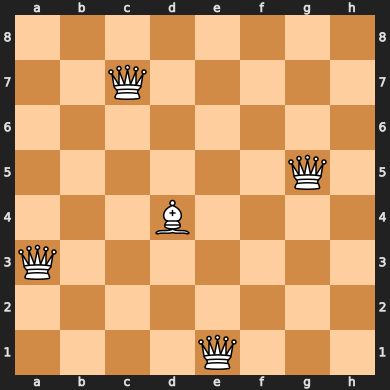

In [14]:
board = chess.Board(fen=None)
for i in range(4):
    board.set_piece_at(pos[i] -1, chess.Piece(chess.QUEEN, chess.WHITE))
board.set_piece_at(pos[-1] -1, chess.Piece(chess.BISHOP, chess.WHITE))

board

### Computing all solutions

In [15]:
from IPython.display import display
import time

start = time.perf_counter()

count = 0
while g.solve():
    count += 1
    cl = []
    
    for lit in g.get_model():
        if lit > 0 and lit <= 4*64:
            cl.append(-(lit + (6 - lit//64) * 64))
        elif lit > 0 and lit <= 5*64:
            cl.append(-lit)
    
    g.add_clause(cl)

print(f'Problem has {count} solutions')

end = time.perf_counter()

print(f"Computed all solutions in {end - start:0.4f} seconds")

Problem has 72 solutions
Computed all solutions in 31.6710 seconds
